before running these cells, you must download the experimental data stored here
https://datadryad.org/stash/dataset/doi:10.5061/dryad.r4xgxd280
and unzip the "MothX_data.mat" files into the current directory.

In [4]:
using MAT
using DelimitedFiles
# using Plots
using CausalityTools
# using LIBSVM
# using ScikitLearn
# using LaTeXStrings
# using Metrics
# using Statistics
using PyCall
np = pyimport("numpy")
using PyPlot
const plt = PyPlot;
using Distributions, Random
# using Printf
using NPZ

In [5]:
Random.seed!(1234);
measure = MIShannon(; base = 2)

nummoths=7
muscleNames = ["LAX","LBA","LSA","LDVM","LDLM",
    "RAX","RBA","RSA","RDVM","RDLM"]
nummuscles=length(muscleNames)

all_tmis=zeros(nummoths,nummuscles)
for mothi in 1:nummoths
    vars = matread("Moth"*string(mothi)*"_data.mat")
    ks = keys(vars)
    score=vars["score"]
    y=score[:,1:2]
    spike_data = vars["spike_data"]
    kss = keys(spike_data)
    
    for musci in 1:nummuscles
        musclename = muscleNames[musci]
        spikes = spike_data[musclename*"spikes"];

        time_data = vars["time_data"]
        ks = keys(time_data)

        strokes = time_data[musclename*"strokes"];

        num_ws = size(strokes)[1]

        spikes=[]
        for ws in 1:num_ws
            strokes_this_ws = strokes[ws,:] # spike timings within this wing stroke
            idx_nan = isnan.(strokes_this_ws)
            idx_notnan = .!idx_nan
            strokes_nonans = strokes_this_ws[idx_notnan]
            spk_count = sum(idx_notnan)
            append!( spikes, spk_count )
        end

        # get spike count probability distribution "pcount"
        histstuff=plt.hist(spikes,bins=np.arange(0.5,maximum(spikes)+1,1)) # exclude spike count = 0
        plt.close()
        num_obs = Int.(histstuff[1]) # number of observations of each spike count
        bin_edges = histstuff[2]
        pcount = num_obs./sum(num_obs)

        # create dictionary to store spike timing distributions conditioned on spike count
        spk_timing_dict = Dict()
        y_dict = Dict() # for storing torques conditioned on spike count
        for spk_count in 1:maximum(spikes)
            key = "spk_count_"*string(spk_count)
            counter_key = "counter_"*string(spk_count)
            spk_timing_dict[counter_key] = 1
            value = zeros(num_obs[spk_count],spk_count)
            spk_timing_dict[key] = value
            yvalue = zeros(num_obs[spk_count],2) # 2 b/c 2 PC's
            y_dict[key] = yvalue
        end

        # go through strokes to put spike timings in dictionary, conditioned on count
        for ws in 1:num_ws
            strokes_this_ws = strokes[ws,:] # spike timings within this wing stroke
            y_this_ws = y[ws,:] # torque PC's within this wingstroke
            idx_nan = isnan.(strokes_this_ws)
            idx_notnan = .!idx_nan
            spk_count = sum(idx_notnan)
            if spk_count < 1
                continue
            else
                strokes_nonans = strokes_this_ws[idx_notnan]
                key = "spk_count_"*string(spk_count)
                counter_key = "counter_"*string(spk_count)
                idx = spk_timing_dict[counter_key]
                spk_timing_dict[key][idx,:] = strokes_nonans
                y_dict[key][idx,:] = y_this_ws
                spk_timing_dict[counter_key] += 1
            end
        end

        # compute timing mutual information
        tmi=0
        for spk_count in 1:maximum(spikes)
            key = "spk_count_"*string(spk_count)
            Stpre = spk_timing_dict[key]
            if size(Stpre)[1] < size(Stpre)[2]
                continue
            else
                St = StateSpaceSet(Stpre)
                tau = StateSpaceSet(y_dict[key])
                mi = mutualinfo(measure, KSG2(k = 3), St, tau)
                tmi += pcount[spk_count]*mi*(mi>0)
            end
        end

#         println(string(tmi)*" bits")
        all_tmis[mothi,musci] = tmi
    end
end

# fig, ax = plt.subplots()
# box = ax.boxplot(all_tmis)
# plt.xticks(np.arange(1,nummuscles,1))

npzwrite("all_tmis.npy", all_tmis)

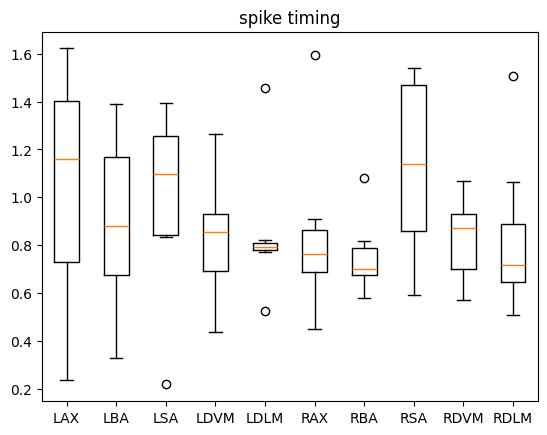

In [6]:
fig, ax = plt.subplots()
box = ax.boxplot(all_tmis)
plt.xticks(np.arange(1,nummuscles+1,1),muscleNames)
plt.title("spike timing")
plt.show()

In [7]:
Random.seed!(1234);
muscleNames = ["LAX","LBA","LSA","LDVM","LDLM",
    "RAX","RBA","RSA","RDVM","RDLM"]
# println(muscleNames)
numMuscles=length(muscleNames)
measure = MIShannon(; base = 2)
d = Normal(0, 0.0001)

numMoths=7
all_cmis = np.zeros((numMoths,numMuscles))
for musci ∈ 1:numMuscles
    muscleName = muscleNames[musci]
    for mothi ∈ 1:numMoths
        filename = "Moth" * string(mothi) * "_data.mat"
        vars = matread(filename)
        spike_data = vars["spike_data"]
        spikes = spike_data[muscleName*"spikes"]
        score = vars["score"]
        noise = rand(d,size(spikes))
        X = StateSpaceSet(spikes .+ noise)
        y = StateSpaceSet(score[:,1:2])
        mi = mutualinfo(measure, KSG2(k = 3), X, y)
        all_cmis[mothi,musci] = mi*(mi>0)
    end
end

npzwrite("all_cmis.npy", all_cmis)

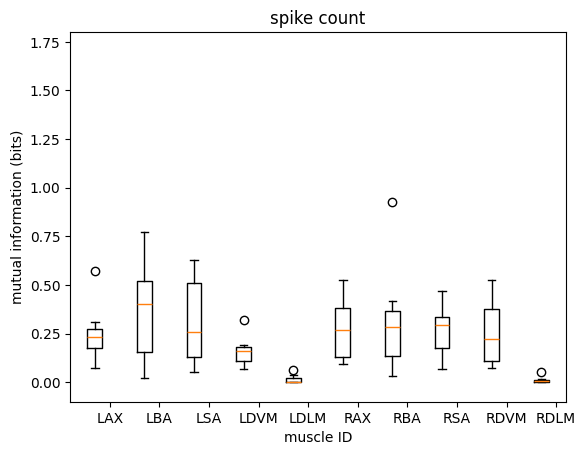

In [8]:
fig, ax = plt.subplots()
box = ax.boxplot(all_cmis,positions=np.arange(0.7,10,1),widths=0.3*np.ones(numMuscles))
# println(box)
# plt.setp(box["boxes"],color="black")
plt.ylim(-0.1,1.8)
plt.title("spike count")
plt.xticks(np.arange(1,numMuscles+1,1),muscleNames)
plt.ylabel("mutual information (bits)")
plt.xlabel("muscle ID")
plt.show()